<a href="https://colab.research.google.com/github/AndresMontesDeOca/TimeSeries/blob/main/TP1_Ale_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP #1


# 0. Inicializacion

## 0.1 Carga de Librerias

In [2]:
!pip install pmdarima
!pip install pingouin
!pip install -q arch

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
import pingouin as pg
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
from scipy.stats import probplot
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera, shapiro



# Ignorar las advertencias específicas de statsmodels
# from statsmodels.tools.sm_exceptions import ValueWarning
# warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore')

# Vamos a suprimir la notacion cientifica
pd.set_option("display.float_format", lambda x:"%.2f" %x)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=1f6a2a7ad63e77a81ca6df8d7abb6d1507effec7833ba6a76864b49c0a53bf3c
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 11.4 MB/s eta 0:00:00


Importamos la Serie

Como tenemos la serie en el Drive, tenemos que improtar una serie de librerias para poder levantar la serie

No olvidar dar los permisos al archivo para poder leer desde el jpynb el mismo.
Luego, copiamso la ruta al archivo, pero solo nos quedamos con el id para acceder al mismo, a continuacion se copia la ruta completa al archivo

https://drive.google.com/file/d/1cuyeVtIy_DOtiADp5cHwNsucJpzhaBqG/view?usp=share_link


Siempre que tenga que leer un archivo que esta en un drive, copiar esta ruta

## 0.2 Carga de Datos

In [3]:
# Code to read csv file into Colaboratory:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Air Pasangers
id = "1LV2t7HpwYpxSumUywyRE1wZ2xyF1KF5I"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('DemHoraria_v2.csv')
dataD = pd.read_csv("DemHoraria_v2.csv", sep=",") # Cargamos el Dataset
data = dataD
######################################################################
# Temperatura
id = "1Lji7usex9EBPQpTgUhAdI6oRnJN9pAxf"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('SerieT20_2022.csv')
dataT = pd.read_csv("SerieT20_2022.csv") # Cargamos el Dataset
######################################################################
# Demanda, Viento, Temperatura ya procesados y unidos en un solo DataFrame
id = "1Lk9Ib0cVa7vtsLXYjycjktIIhBzS3zdX"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('data_DTV.csv')
dataDVT = pd.read_csv("data_DTV.csv", parse_dates=['Fecha'], index_col='Fecha') # Cargamos el Dataset

# 1. Preprocesamiento

## 1.1 DataFrame data (Demanda y Viento)

In [4]:
# Convertimos la columna "data_hora" a tipo de datos de fecha y hora
data["data_hora"]= pd.to_datetime(data["data_hora"], format="%Y-%m-%d %H")

# Renombramos las variables
data.rename(columns={"Demanda_MW": "Demanda", "data_hora":"Fecha", "Vel_viento": "Viento"}, inplace=True)

# Seteamos la Fecha como Index
data=data.set_index("Fecha")

# Filtrar los datos para los años 2020, 2021 y 2022
data = data['2020':'2022']

# Dividimos el DataFrame
dataD = data[['Demanda']]
dataV = data[['Viento']]

# display(data.head())
# display(dataD.head())
# display(dataV.head())

## 1.2 DataFrame dataT (Temperatura)

In [5]:
# Eliminamos Nulos
dataT = dataT.dropna()

# Renombramos las variables
dataT.rename(columns={"TempAire": "Temperatura"}, inplace=True)

# Convertimos la columna "Fecha" a tipo de datos de fecha y hora
dataT["Fecha"]= pd.to_datetime(dataT["Fecha"], format='%m/%d/%Y %H:%M')

# Seteamos la Fecha como Index
dataT=dataT.set_index("Fecha")

# print(dataT.describe())

## 1.3 Analisis de Demanda

### 1.3.1 Limpeza de Valores Atipicos
Ya no es necesario porque filtramos por ano 2020, 2021, y 2022

In [6]:
# Poniendo en nulos los valores menores a 83 o mayores a 2300
dataD['Demanda'] = dataD['Demanda'].apply(lambda x: x if (x >= 83 and x <= 2300) else None)

# Realizando backfill para llenar los valores nulos/fuera de rabgo
dataD['Demanda'].fillna(method='backfill', inplace=True)

# Al recortar el Dataset original a los datos de los anos 2020, 2021 y 2022, esto ya no es necesario

### 1.3.2 Agregacion por Dia

In [7]:
# Tener el corte por hora no tiene mucho sentido para el Analisis
# Ademas, las notebook corren muy lento con tantos datos

# El corte por hora es muy atomizado, agregamos por dia
dataD_daily = dataD['Demanda'].resample('D').sum()

# Seguimos con la variable dataD
dataD = dataD_daily.to_frame() # Lo paso a Pandas DataFrame, sino me lo transforma a Pandas Series

## 1.4 Analisis del Viento

In [8]:
# Corregimos los valores rotos, ponemos en null los > a 100
dataV.loc[dataV['Viento'] > 100, 'Viento'] = None

# Completar los valores nulos con el método backfill en dataV_filtered
dataV.fillna(method='bfill', inplace=True)

# Calcular el promedio diario del viento
dataV = dataV.resample('D').mean()

## 1.4 Analisis de la Temperatura

In [9]:
# Completar los valores nulos con el método backfill
dataT.fillna(method='bfill', inplace=True)

# Agregar por Average o Maximo diario
dataT = dataT.resample('D').mean()

## 1.5 Union Datasets

In [10]:
# Comparar los índices de data1 y data3 para encontrar diferencias
differences = dataD.index.difference(dataT.index)

# Crear un nuevo DataFrame con los índices faltantes y todas las columnas en NaN
missing_indices = pd.DataFrame(index=differences)

# Unir este nuevo DataFrame con data3, manteniendo todos los valores de data3 y poniendo NaN en los valores faltantes
dataT = dataT.combine_first(missing_indices)

# Ordenar el DataFrame por el índice
dataT.sort_index(inplace=True)

# Comparar los índices de data1, data2 y data3 para verificar si son iguales
indices_equal = (dataD.index.equals(dataV.index) and dataV.index.equals(dataT.index))
print('Indices sincronizados:', indices_equal)

# Concatenacion, Todavia no, primero tengo que curar cara serie por separado
data = pd.concat([dataD, dataV, dataT], axis=1)

print(data.info())
display(data.head())

Indices sincronizados: True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2020-01-01 to 2022-12-31
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demanda      1096 non-null   float64
 1   Viento       1096 non-null   float64
 2   Temperatura  1096 non-null   float64
dtypes: float64(3)
memory usage: 34.2 KB
None


,Demanda,Viento,Temperatura
Fecha,,,
2020-01-01,24206.06,12.64,21.15
2020-01-02,28478.32,17.04,21.25
2020-01-03,29702.44,18.04,21.81
2020-01-04,28617.39,16.59,21.31
2020-01-05,28215.97,16.60,23.75


## 1.6 Funciones Auxiliares

### 1.6.1 Funcion "estacionariedad"
Test Analitico de ADF

In [11]:
# Funciones Auxiliares para el Analisis Analitco de Estacionariedad

from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def estacioneriedad(y):
  kpss_pvalue = kpss(y)[1]
  adf_pvalue = adfuller(y)[1]
  pp = PhillipsPerron(y)
  print('ADF:', adf_pvalue)
  print('KPSS:', kpss_pvalue, '\n')
  print('PP:', pp, '\n')

# print('p-values de los distintos test:\n')
# print('KPSS (Kwiatkowski-Phillips-Schmidt-Shin)', kpss_pvalue)
# print('Dickey-Fuller Aumentada (ADF):', np.round(adf_pvalue, 4), '\n')
# print(pp)


# # Funcion dada por el profe, no la vamos a usar
# # Augmented Dickey–Fuller test
# def estacioneriedad(y):
#   resultado = adfuller(y)
#   # print('Estadistico ADF: %f' % resultado[0])
#   print('p-valor: %f' % resultado[1])
#   # print('Valores criticos:')
#   # for key, valor in resultado[4].items():
#   #   print('\t%s: %.3f' % (key, valor))
#   if resultado[1] < 0.05:
#     print('Serie Estacionaria')
#   else:
#     print('Serie no Estacionaria')

### 1.6.2 Funcion "diferenciacion"
Distintos tests que devuelven el d optimo para diferenciar

In [12]:
# Para obtener el d optimo a diferenciar
def diferenciacion(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)


  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  # print('Se debe realizar diferenciación (should_diff) ADF Test')
  # adftest = ADFTest(alpha=0.05)
  # print(adftest.should_diff(y))

### 1.6.3 Funcion "evaluar_metricas"
Metricas que evaluan la performance de los valores predichos por el modelo

In [13]:

#Función para evaluar los modelos contra el test en MSE, MAE, RMSE, MAPE

def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

### 1.6.4 Funcion "residuos_evaluation"
Distintos Tests Analiticos y Graficos para el Analisis de los Residuos

In [14]:
# Diferentes Tests de Normalidad
def residuos_normality(residuos):
  # Test Grafico
  pg.qqplot(residuos, dist='norm')
  plt.title('Normalidad de los Residuos')
  plt.show()

  # Test Analitico
  jarquebera = jarque_bera(residuos)[1]
  shapir = shapiro(residuos)[1]
  print('Shapiro p-value:', shapir)
  print('Jarque-Bera p-value:', jarquebera, '\n')

# Diferentes Tests de Autocorrelacion
def residuos_autocorrelation(residuos):
  # Test Grafico
  plot_acf(residuos, lags=30)
  plt.title('Autocorrelacion de los Residuos')
  plt.show()
  # Tests Analiticos
  dw = sm.stats.stattools.durbin_watson(residuos)
  lb = sm.stats.acorr_ljungbox(residuos, lags=[30], return_df=True)
  print('Durbin-Watson (~2 = No-Autocorrelation):', dw)
  print('Ljung-Box p-value:', lb.lb_pvalue.values, 3)

# Test Grafico de Homocedasticidad, el Analitco no lo pude hacer funcionar
def residuos_homocedasticity(residuos):
  # Grafico
  plt.scatter(range(len(residuos)), residuos)
  plt.axhline(y=0, color='r', linestyle='--')
  plt.xlabel('Tiempo')
  plt.ylabel('Residuos')
  plt.title('Homocedasticidad - Residuos a lo Largo del Tiempo')
  plt.show()

  # Analitico
  # Breusch-Pagan, pero no lo pude hacer funcionar

# Llama a todos los test anteriores, mas la media
def residuos_evaluation(residuos):
  print('Media de los Residuos', residuos.mean())
  residuos_normality(residuos)
  residuos_autocorrelation(residuos)
  residuos_homocedasticity(residuos)

# 2. Graficar las series originales
- Analizar si es necesario diferenciarlas para convertirlas en estacionarias
- Exponer los conceptos relacionados con la estacionariedad de la serie.

## 2.1 Visualizacion Individual de las Series Originales

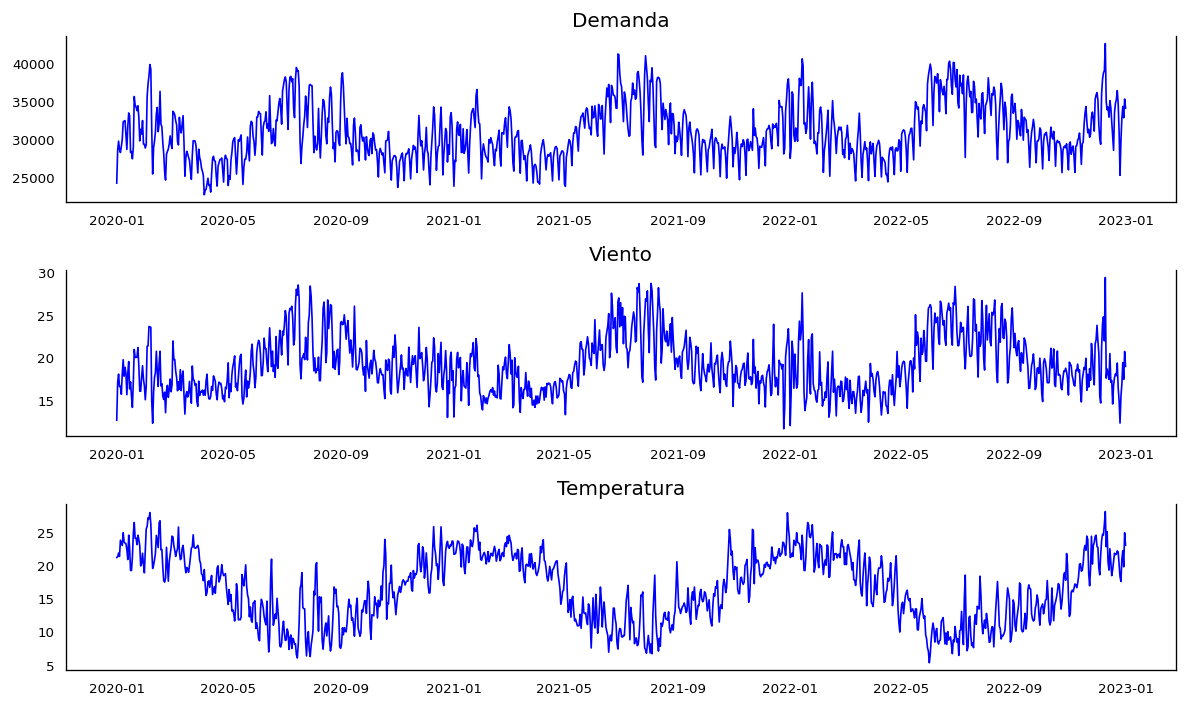

In [15]:
# Plot each time series in the dataset
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_column = data.columns[i]
    ax.plot(data[data_column], color='blue', linewidth=1)
    # Decorate
    ax.set_title(data_column)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)

plt.tight_layout();

- En las series originales no podemos distinguir bien la Estacionariedad, debemos hacer una Descomposicion de las mismas

## 2.2 Visualizacion Conjunta de las Series Normalizadas

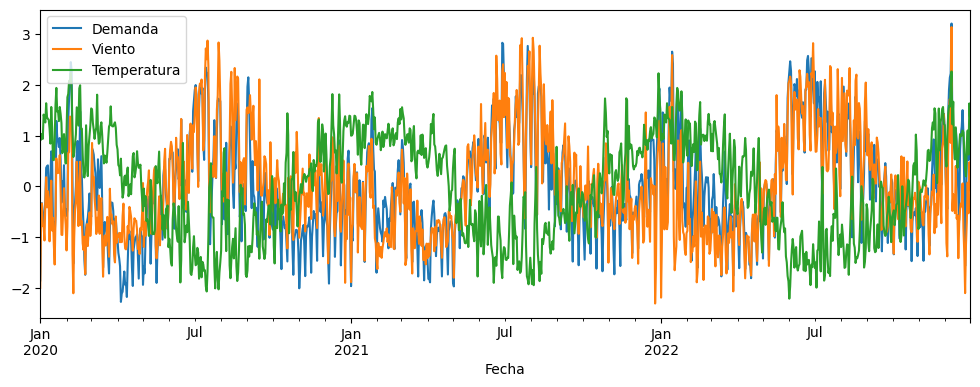

In [16]:
# Normalizamos para comprar las tres series en un solo plot
from scipy.stats import zscore

dataN = data.apply(zscore)

dataN.plot(figsize=(12, 4))
plt.show()

- Pareciera ser que Demanda y Viento estan muy correlacionadas
- Tambien pareciera ser que la Temperatura esta inversamente correlacionada con las Demanda y Viento.

## 2.3 Descomposiciones de las Series Originales

### 2.3.1 Descomposicion de Demanda

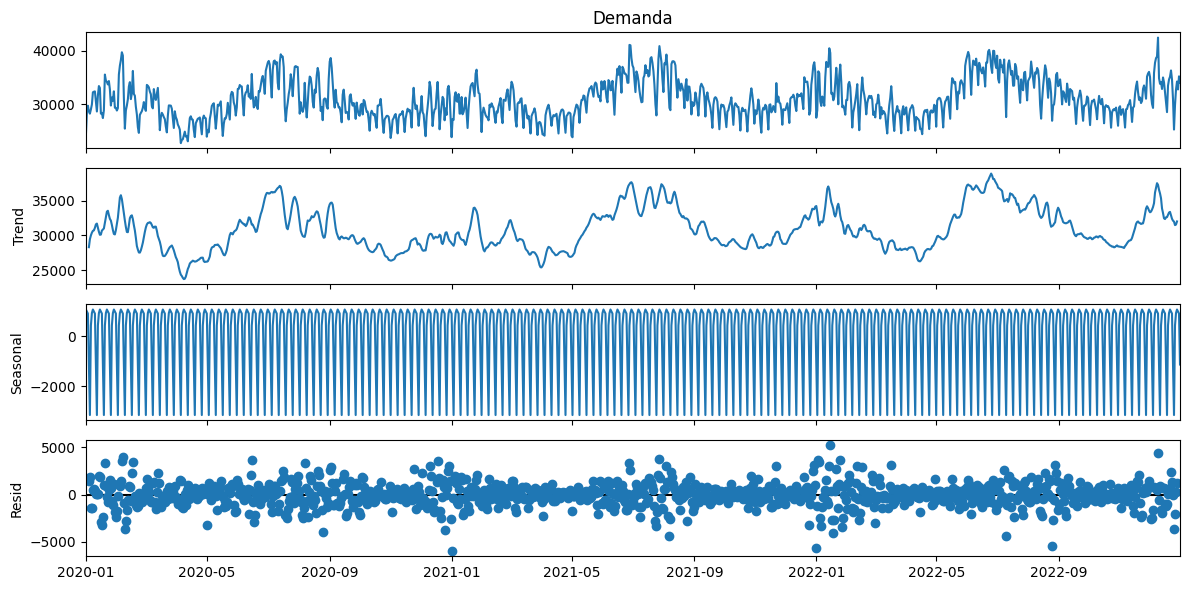

In [17]:
# Plot the decomposed components
plt.rcParams['figure.figsize'] = [12, 6]

decompose_demanda = seasonal_decompose(data['Demanda'], model='additive')
decompose_demanda.plot()
plt.show()

- Se puede observar que la Serie tiene un leve tendencia al alza
- Tambien se observa una Estacionalidad importante
- Por ambas razones, podemos deducir que la serie es No-Estacionaria, y que es recomendable realizar alguna diferenciacion

### 2.3.2 Descomposicion del Viento

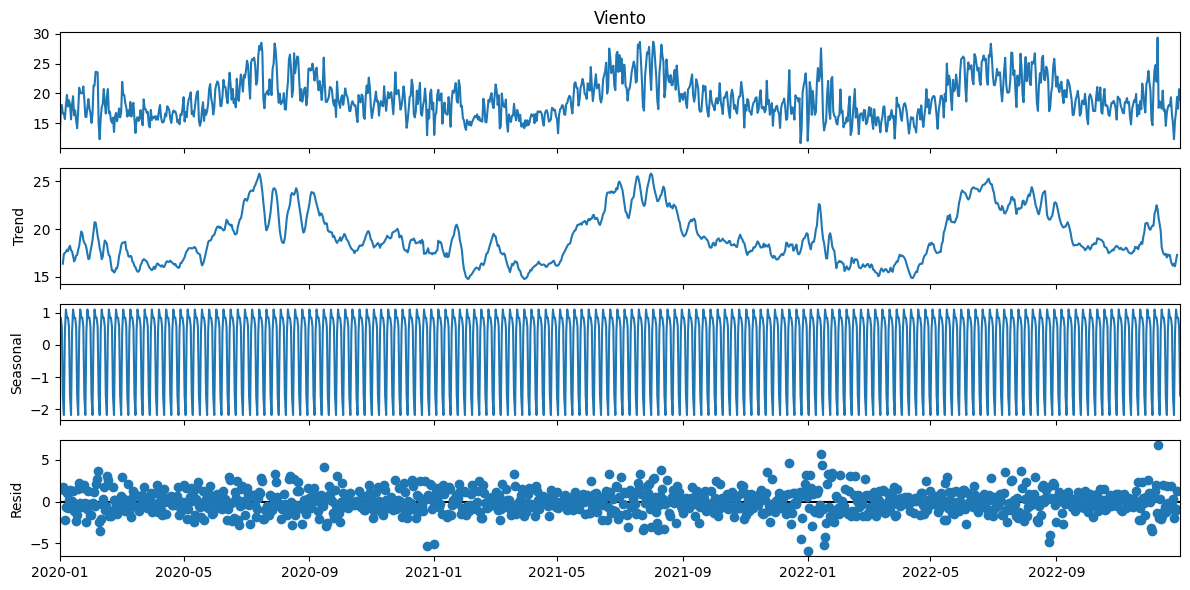

In [18]:
# Plot the decomposed components
plt.rcParams['figure.figsize'] = [12, 6]

decompose_viento = seasonal_decompose(data['Viento'], model='additive')
decompose_viento.plot()
plt.show()

- La Serie del Viento pareciara no tener un Trend tan marcado
- Sin embargo si se observa una Estacionalidad considerable, asi que tampoco podemos decir que es Estacionaria

### 2.3.2 Descompsicion de la Temperatura

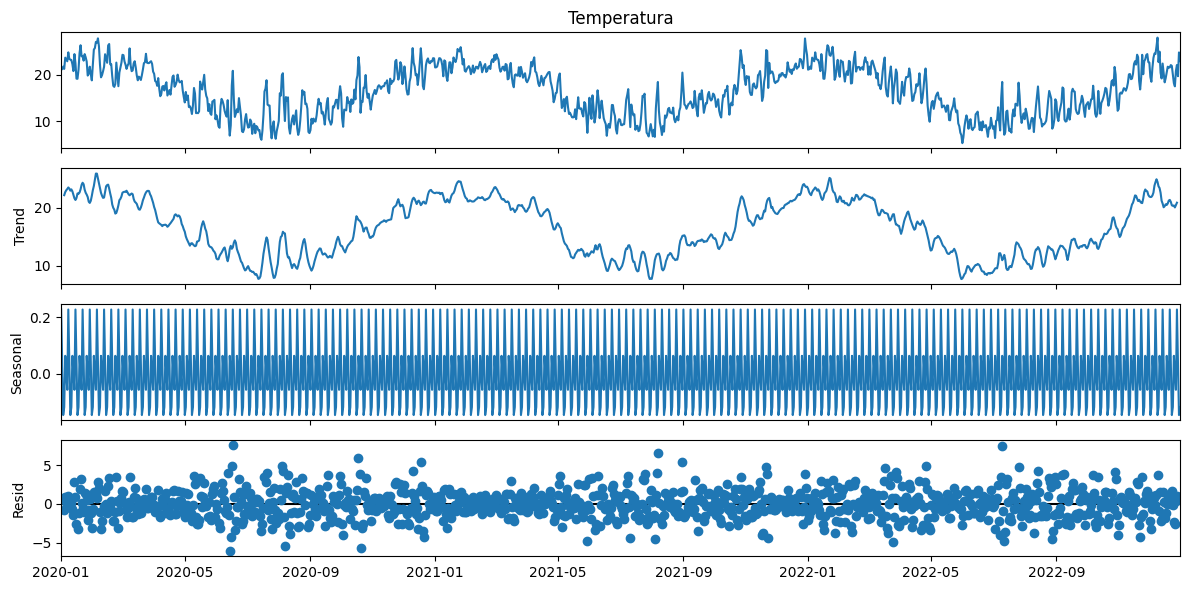

In [19]:
# Plot the decomposed components
plt.rcParams['figure.figsize'] = [12, 6]

decompose_temperatura = seasonal_decompose(data['Temperatura'], model='additive')
decompose_temperatura.plot()
plt.show()

- Aqui tampoco se observa un Trend
- Pero si se observa una Estacionalidad
- Realizar una Diferenciacion es recomendable, para logar la Estacionariedad de la Serie

# 3. Graficar la FAS, FAC y FACP y analizarlas.
- Que se infiere de los graficos?
- Justificar con la Teoria

## 3.1 Demanda

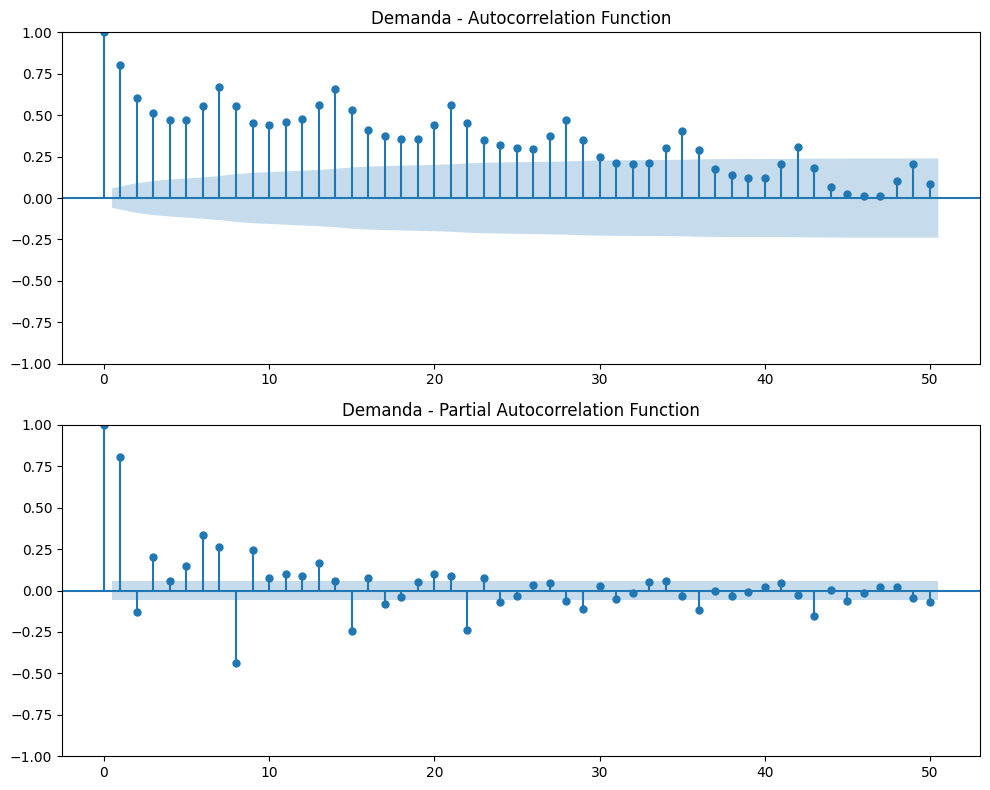

In [20]:
# Graficamos las Funciones de Autocorrelacion

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF y PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ACF
plot_acf(data['Demanda'], ax=ax1, lags=50)
ax1.set_title('Demanda - Autocorrelation Function')

# PACF
plot_pacf(data['Demanda'], ax=ax2, lags=50)
ax2.set_title('Demanda - Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

- ACF (Autocorrelation Function): Muestra la correlación de la serie consigo misma en diferentes lags. Si la serie fuera estacionaria, esperaríamos que las autocorrelaciones se redujeran rápidamente a cero. Sin embargo, en esta gráfica, las autocorrelaciones se mantienen significativas (fuera del área azul sombreada que representa el intervalo de confianza) para muchos lags, lo que sugiere que la serie no es estacionaria. Tambien se observan los "latigazos" cada 7 unidades, lo que indica que la Serie podria tener una Estacionalidad Semanal
- PACF (Partial Autocorrelation Function): Muestra la correlación parcial de la serie consigo misma, controlando por las correlaciones de todos los lags más cortos. La PACF corta bruscamente después del primer lag, lo que indica que una Diferenciacion de Orden 1 es recomendable
- Por lo anterior, la Serie pareciera ser No-Estacionaria

## 3.2 Viento

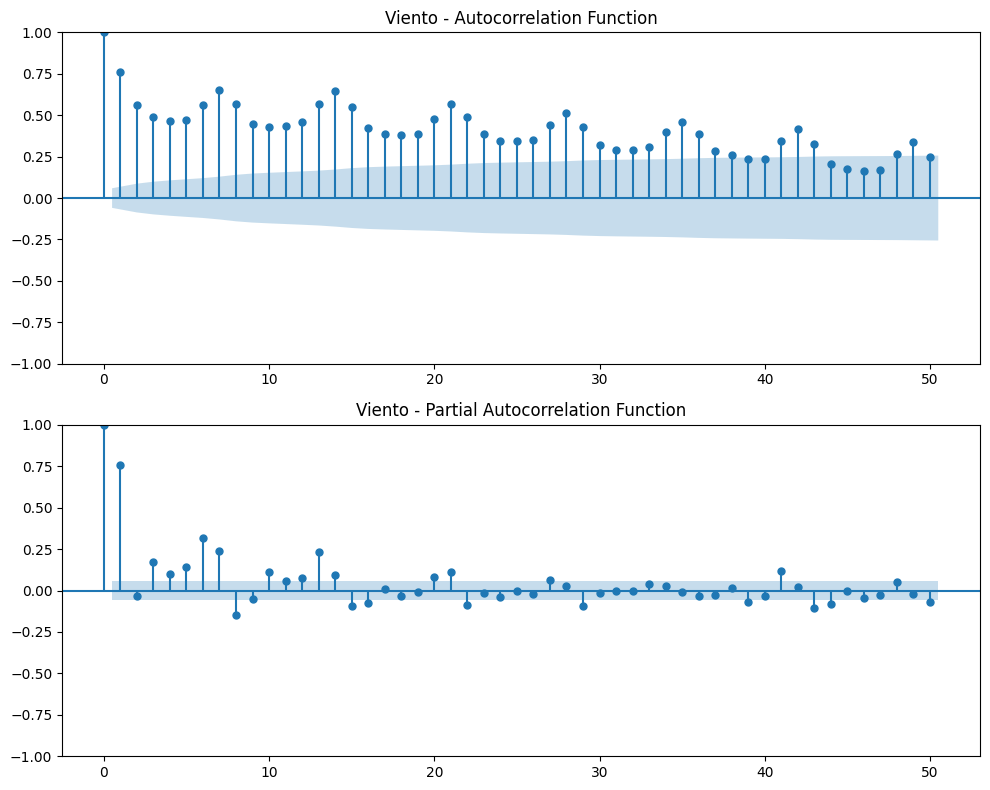

In [21]:
# Graficamos las Funciones de Autocorrelacion

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF y PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ACF
plot_acf(data['Viento'], ax=ax1, lags=50)
ax1.set_title('Viento - Autocorrelation Function')

# PACF
plot_pacf(data['Viento'], ax=ax2, lags=50)
ax2.set_title('Viento - Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

- Tambien se observa la Estacionalidad Semanal. **Esto me parece muy raro**, ya que el viento no deberia estar relacionado con el dia de la semana
- Tambien es recomendable una Diferenciacion de Orden 1
- La Serie pareciera ser No-Estacionaria

## 3.3 Temperatura

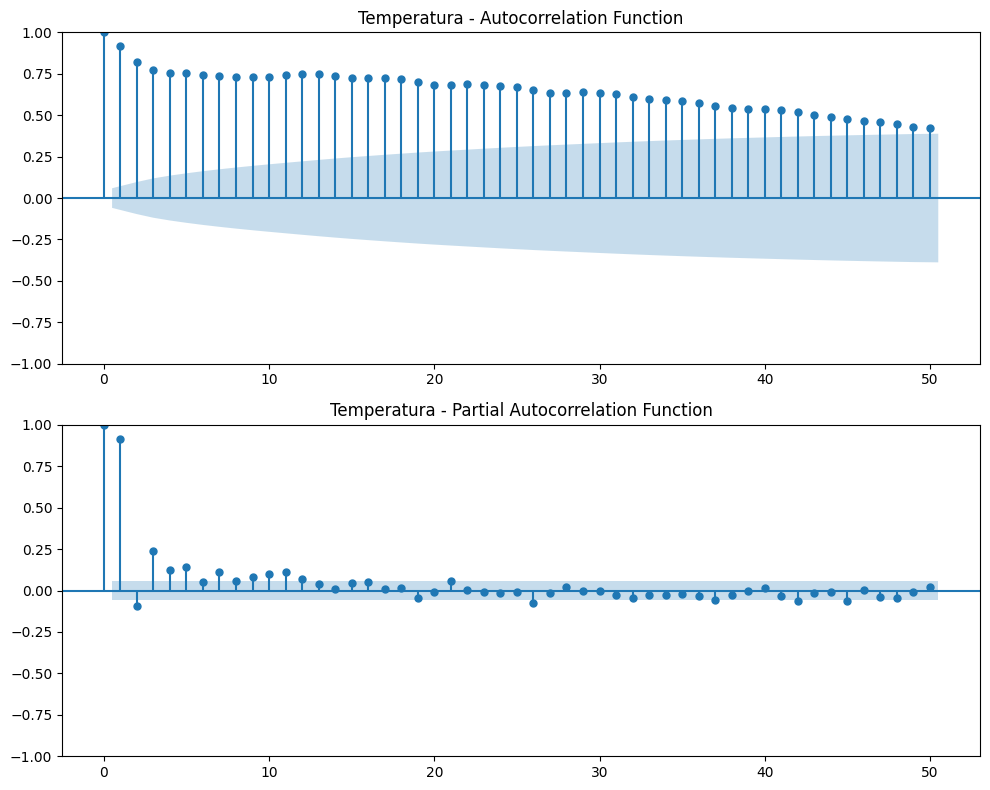

In [22]:
# Graficamos las Funciones de Autocorrelacion

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF y PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ACF
plot_acf(data['Temperatura'], ax=ax1, lags=50)
ax1.set_title('Temperatura - Autocorrelation Function')

# PACF
plot_pacf(data['Temperatura'], ax=ax2, lags=50)
ax2.set_title('Temperatura - Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

- Aqui no se observa Estacionalidad en el grafico de ACF, pero al no decaer bruscamente podemos inducir en que la serie tiene Trend
- En el PACF tambien se ve como es recomendable la Diferenciacion de Orden 1
- Esta Serie tampoco pareciera ser Estacionaria

# 4. Realizar distintas pruebas de raíces unitarias
REVISAR Y CORREGIR

In [23]:
# Demanda
print('Serie Demanda')
estacioneriedad(data['Demanda'])

# Viento
print('Serie Viento')
estacioneriedad(data['Viento'])

# Temperatura
print('Serie Temperatura')
estacioneriedad(data['Temperatura'])

Serie Demanda
ADF: 0.038489901952593324
KPSS: 0.025082221323608614 

PP:      Phillips-Perron Test (Z-tau)    
Test Statistic                -13.037
P-value                         0.000
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

Serie Viento
ADF: 0.0984173019729015
KPSS: 0.1 

PP:      Phillips-Perron Test (Z-tau)    
Test Statistic                -15.749
P-value                         0.000
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

Serie Temperatura
ADF: 0.3381686734046215
KPSS: 0.1 

PP:      Phillips-Perron Test (Z-tau)    
Test Statistic                 -6.61

- Aca hay que explicar los p-values, y compararlos con lo visto en las graficas de ACF y PACF
- No todos los test graficos/analiticos muestran lo mismo, se llegan a distintas conclusiones

- Teniendo en cuenta que los p-values obtenidos en los test de ADF y KPSS, que son bastante border, mas las contradicciones en los Tests Graficos, decidimos tratar las tres series como No-Estacionarias

In [24]:
# Tests Analiticos de Diferenciacion

from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

kpss_pvalue = kpss(data['Demanda'])[1]
adf_pvalue = adfuller(data['Demanda'])[1]
pp = PhillipsPerron(data['Demanda'])

print('p-values de los distintos test:\n')
print('KPSS (Kwiatkowski-Phillips-Schmidt-Shin)', kpss_pvalue)
print('Dickey-Fuller Aumentada (ADF):', np.round(adf_pvalue, 4), '\n')
print(pp)



p-values de los distintos test:

KPSS (Kwiatkowski-Phillips-Schmidt-Shin) 0.025082221323608614
Dickey-Fuller Aumentada (ADF): 0.0385 

     Phillips-Perron Test (Z-tau)    
Test Statistic                -13.037
P-value                         0.000
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


- La H0 del test de KPSS indica la estacionariedad, la cual rechazamos con un p-value obtenido del 0.01%
- En cambio los tests de ADF y PP, con ambos p-values casi del 0%, rechazan la H0 de no-estacionariedad
- Los diferentes test nos arrojan valores contradictorios


# 5. Estimaciones con distintos parametros en ARIMA/SARIMA

## 5.1 Serie de Demanda

### 5.1.1 Con Estacionalidad Semanal (SARIMA)

In [25]:
# # Usamos AUTO-Arima con Estaiconalidad Semanal para encontrar el mejor modeloo_arima

# # Utilizar auto_arima para identificar los mejores parámetros con estacionalidad semanal
# stepwise_fit = auto_arima(data['Demanda'], start_p=1, start_q=1,
#                           max_p=3, max_q=3, m=7,
#                           start_P=0, start_Q=0, seasonal=True,
#                           d=None, D=1, trace=True,
#                           error_action='ignore',
#                           suppress_warnings=True,
#                           stepwise=True)

# # Resumen de los resultados
# stepwise_fit.summary()

- Indicandole al modelo la presencia de Estacionalidad Semanal (m=7), el mejor modelo encontrado es: ARIMA(3,0,1)(0,1,1)[7], con un Akaike de 18946.909


### 5.1.2 Con Diferenciacion, sin Estacionalidad (ARIMA)

In [26]:
# # Usamos AUTO-Arima con Estaiconalidad Semanal para encontrar el mejor modelo
# # Utilizar auto_arima para identificar los mejores parámetros con estacionalidad semanal
# stepwise_fit = auto_arima(data['Demanda'], start_p=1, start_q=1,
#                           max_p=3, max_q=3, m=1,
#                           start_P=0, start_Q=0, seasonal=True,
#                           d=1, D=0, trace=True,
#                           error_action='ignore',
#                           suppress_warnings=True,
#                           stepwise=True)

# # Resumen de los resultados
# stepwise_fit.summary()

- El mejor modelo ARIMA, seria el ARIMA(3,1,2)(0,0,0), con in Akaike de 19763.873
- Confirmamos que el AIC es considerablemente mayor al obtenido en el modelo con Estacionalidad (SARIMA), lo que era de esperar ya que la Serie Demanda tiene Estacionalidad Semanal


## 5.2 Serie de Viento

### 5.2.1 Con Estacionalidad Semanal (SARIMA)

In [27]:
# # Usamos AUTO-Arima con Estaiconalidad Semanal para encontrar el mejor modelo

# # Utilizar auto_arima para identificar los mejores parámetros con estacionalidad semanal
# stepwise_fit = auto_arima(data['Viento'], start_p=1, start_q=1,
#                           max_p=3, max_q=3, m=7,
#                           start_P=0, start_Q=0, seasonal=True,
#                           d=None, D=1, trace=True,
#                           error_action='ignore',
#                           suppress_warnings=True,
#                           stepwise=True)

# # Resumen de los resultados
# stepwise_fit.summary()

- Best model:  ARIMA(0,0,3)(0,1,1)[7] -> AIC: 4418.907


### 5.2.2 Con Diferenciacion, sin Estacionalidad (ARIMA)

In [28]:
# # Usamos AUTO-Arima con Estaiconalidad Semanal para encontrar el mejor modelo

# # Utilizar auto_arima para identificar los mejores parámetros con estacionalidad semanal
# stepwise_fit = auto_arima(data['Viento'], start_p=1, start_q=1,
#                           max_p=3, max_q=3, m=1,
#                           start_P=0, start_Q=0, seasonal=True,
#                           d=1, D=0, trace=True,
#                           error_action='ignore',
#                           suppress_warnings=True,
#                           stepwise=True)

# # Resumen de los resultados
# stepwise_fit.summary()

- Best model:  ARIMA(2,1,2)(0,0,0) -> AIC: 	4604.514
- Al tener una Estacionalidad Semanal, como era de esperar el mejor modelo SARIMA pareciera ser considerablmente mejor al mejor ARIMA

## 5.3 Serie de Temperatura

### 5.3.1 Con Estacionalidad Semanal (SARIMA)

In [29]:
# # Usamos AUTO-Arima con Estaiconalidad Semanal para encontrar el mejor modelo

# # Utilizar auto_arima para identificar los mejores parámetros con estacionalidad semanal
# stepwise_fit = auto_arima(data['Temperatura'], start_p=1, start_q=1,
#                           max_p=3, max_q=3, m=7,
#                           start_P=0, start_Q=0, seasonal=True,
#                           d=None, D=1, trace=True,
#                           error_action='ignore',
#                           suppress_warnings=True,
#                           stepwise=True)

# # Resumen de los resultados
# stepwise_fit.summary()

-Best model:  ARIMA(2,0,1)(0,1,1)[7] -> AIC: 4667.262


### 5.3.2 Con Diferenciacion, sin Estacionalidad (ARIMA)

In [30]:
# # Usamos AUTO-Arima con Estaiconalidad Semanal para encontrar el mejor modelo

# # Utilizar auto_arima para identificar los mejores parámetros con estacionalidad semanal
# stepwise_fit = auto_arima(data['Temperatura'], start_p=1, start_q=1,
#                           max_p=3, max_q=3, m=1,
#                           start_P=0, start_Q=0, seasonal=True,
#                           d=1, D=0, trace=True,
#                           error_action='ignore',
#                           suppress_warnings=True,
#                           stepwise=True)

# # Resumen de los resultados
# stepwise_fit.summary()

- Best model:  ARIMA(3,1,2)(0,0,0)[0] -> AIC: 4512.050
- Como habiamos senalado cuando analizamos las los graficos de las funciones de ACF, la Serie de Temperatura no presentaba una Estacionalidad Semanal, como si se veia en Demanda y Viento
- Por lo anterior el modelo ARIMA nos da un Akaike mas chico que el SARIMA para la Serie de Temperatura

# 6. Division Train/Test, Creacion de Modelos y Metricas de Performance

## 6.1 Division del Dataset

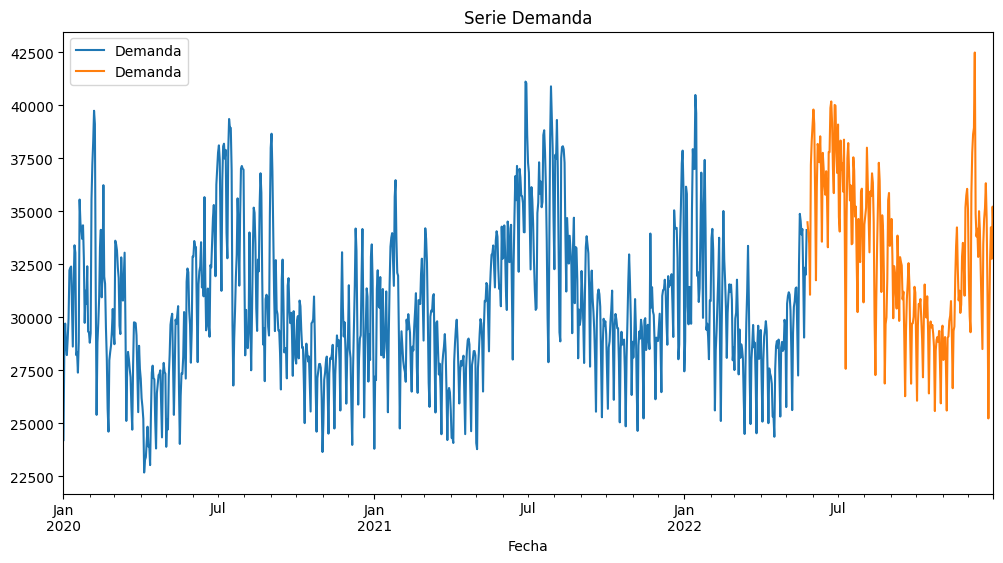

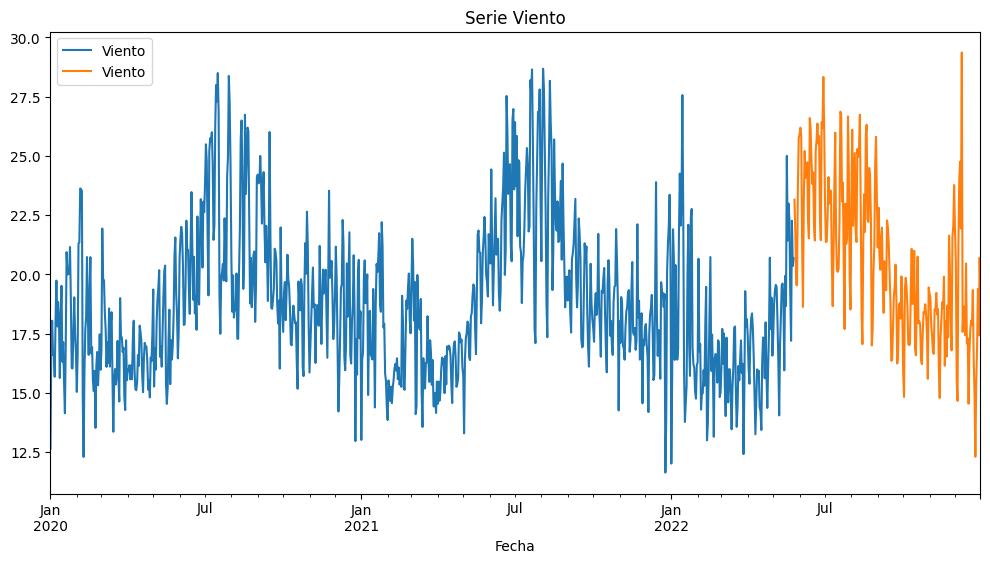

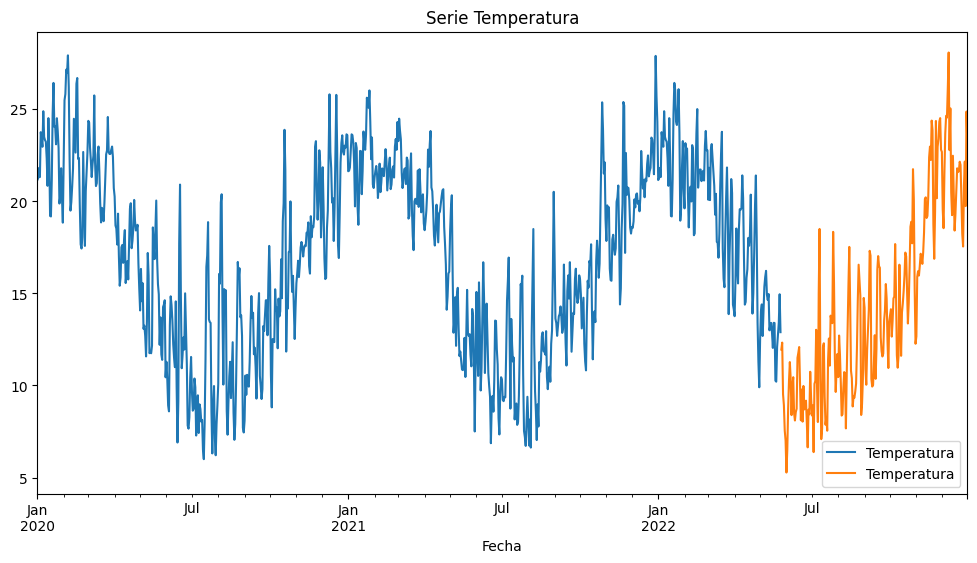

In [31]:
# Determine the split point for 80% train and 20% test
split_point = int(len(data) * 0.8)

# Split the data into train and test sets.
train = data.iloc[:split_point]
test = data.iloc[split_point:]

# Ploteamos Demanda
pd.concat([train['Demanda'], test['Demanda']], axis=1).plot()
plt.title('Serie Demanda')
plt.show()

# Ploteamos Viento
pd.concat([train['Viento'], test['Viento']], axis=1).plot()
plt.title('Serie Viento')
plt.show()

# Ploteamos Temperatura
pd.concat([train['Temperatura'], test['Temperatura']], axis=1).plot()
plt.title('Serie Temperatura')
plt.show()

## 6.2 Creacion de Modelos

### 6.2.1 Serie de Demanda

In [32]:
# Creamos los modelos con los parametros optimos descubiertos anteriormente

# Mejor SARIMA
modelo_demanda_sarima = SARIMAX(train['Demanda'], order=(3,0,1), seasonal_order=(0,1,1,7)).fit()
pred_demanda_sarima = modelo_demanda_sarima.get_forecast(len(test['Demanda'])).predicted_mean

# Mejor ARIMA
modelo_demanda_arima = ARIMA(train['Demanda'], order=(3,1,2), seasonal_order=(0, 0, 0, 0)).fit()
pred_demanda_arima = modelo_demanda_arima.get_forecast(len(test['Demanda'])).predicted_mean

### 6.2.2 Serie de Viento

In [33]:
# Creamos los modelos con los parametros optimos descubiertos anteriormente

# Mejor SARIMA
modelo_viento_sarima = SARIMAX(train['Viento'], order=(0,0,3), seasonal_order=(0,1,1,7)).fit()
pred_viento_sarima = modelo_demanda_sarima.get_forecast(len(test['Viento'])).predicted_mean

# Mejor ARIMA
modelo_viento_arima = ARIMA(train['Viento'], order=(2,1,2), seasonal_order=(0, 0, 0, 0)).fit()
pred_viento_arima = modelo_demanda_arima.get_forecast(len(test['Viento'])).predicted_mean

### 6.2.3 Serie de Temperatura

In [34]:
# Creamos los modelos con los parametros optimos descubiertos anteriormente

# Mejor SARIMA
modelo_temperatura_sarima = SARIMAX(train['Temperatura'], order=(0,0,3), seasonal_order=(0,1,1,7)).fit()
pred_temperatura_sarima = modelo_demanda_sarima.get_forecast(len(test['Temperatura'])).predicted_mean

# Mejor ARIMA
modelo_temperatura_arima = ARIMA(train['Temperatura'], order=(2,1,2), seasonal_order=(0, 0, 0, 0)).fit()
pred_temperatura_arima = modelo_demanda_arima.get_forecast(len(test['Temperatura'])).predicted_mean

## 6.3 Evaluacion de la Performance de los Modelos

### 6.3.1 Serie de Demanda

In [35]:
# Usamos la Funcion Aixiliar sobre el mejor modelo SARIMA
print('Modelo SARIMA:')
print(evaluar_metricas(test['Demanda'], pred_demanda_sarima))

# Usamos la Funcion Aixiliar sobre el mejor modelo ARIMA
print('Modelo ARIMA:')
print(evaluar_metricas(test['Demanda'], pred_demanda_arima))

Modelo SARIMA:
MSE: 10622703.79933411
MAE: 2824.029822794999
RMSE: 3259.2489624657564
MAPE: 0.0855
None
Modelo ARIMA:
MSE: 13186608.80352358
MAE: 3045.692332576268
RMSE: 3631.3370545191174
MAPE: 0.0918
None


- Confirmamos lo visto anteriormente, la Serie de Demanda tiene un componente Estacional semanal, por consiguiente todas las metricas son mejores en el modelo SARIMA que en el ARIMA

### 6.3.2 Serie de Viento

In [36]:
# Usamos la Funcion Aixiliar sobre el mejor modelo SARIMA
print('Modelo SARIMA:')
print(evaluar_metricas(test['Viento'], pred_viento_sarima))

# Usamos la Funcion Aixiliar sobre el mejor modelo ARIMA
print('Modelo ARIMA:')
print(evaluar_metricas(test['Viento'], pred_viento_arima))

Modelo SARIMA:
MSE: 1061100324.2550216
MAE: 32542.032573952805
RMSE: 32574.534904661672
MAPE: 1611.3673
None
Modelo ARIMA:
MSE: 1039567334.5713292
MAE: 32242.075553907158
RMSE: 32242.322102654598
MAPE: 1601.5665
None


- Al contrario que en la Serir de Demanda, la Serie de Viento no tiene un componete Estacional Semanal, por ende todas las metricas del mejor Modelo ARIMA son mejores que el del mejor Modelo SARIMA

### 6.3.3 Serie de Temperatura

In [37]:
# Usamos la Funcion Aixiliar sobre el mejor modelo SARIMA
print('Modelo SARIMA:')
print(evaluar_metricas(test['Temperatura'], pred_temperatura_sarima))

# Usamos la Funcion Aixiliar sobre el mejor modelo ARIMA
print('Modelo ARIMA:')
print(evaluar_metricas(test['Temperatura'], pred_temperatura_arima))

Modelo SARIMA:
MSE: 1061511042.9369137
MAE: 32548.28427484903
RMSE: 32580.83858553849
MAPE: 2560.7549
None
Modelo ARIMA:
MSE: 1039970608.7654083
MAE: 32248.327254803386
RMSE: 32248.57529822687
MAPE: 2538.4279
None


- En la Serie de Temperatura tambien verificamos que no hay Estacionalidad Semanal, y por consiguiente todas las Metricas de performance del mejor Modelo ARIMA son mejores que la del mejor Modelo SARIMA

# 7. Comparacion con otros modelos estimados

In [38]:
metricas_modelos = {'Modelos': ['Demanda SARIMA', 'Demanda ARIMA', 'Viento SARIMA','Viento ARIMA', 'Temperatura SARIMA', 'Temperatura ARIMA'],
         'AIC': [modelo_demanda_sarima.aic, modelo_demanda_arima.aic, modelo_viento_sarima.aic, modelo_viento_arima.aic, modelo_temperatura_sarima.aic, modelo_temperatura_arima.aic],
         'BIC': [modelo_demanda_sarima.bic, modelo_demanda_arima.bic, modelo_viento_sarima.bic, modelo_viento_arima.bic, modelo_temperatura_sarima.bic, modelo_temperatura_arima.bic],
         'MAE': [modelo_demanda_sarima.mae, modelo_demanda_arima.mae, modelo_viento_sarima.mae, modelo_viento_arima.mae, modelo_temperatura_sarima.mae, modelo_temperatura_arima.mae],
         'MSE': [modelo_demanda_sarima.mse, modelo_demanda_arima.mse, modelo_viento_sarima.mse, modelo_viento_arima.mse, modelo_temperatura_sarima.mse, modelo_temperatura_arima.mse]
}

comparacion_modelos = pd.DataFrame(metricas_modelos)
comparacion_modelos

,Modelos,AIC,BIC,MAE,MSE
0,Demanda SARIMA,15052.00,15080.60,1132.91,3734538.11
1,Demanda ARIMA,15769.91,15798.56,1594.40,4547534.99
2,Viento SARIMA,3505.98,3529.81,1.51,5.45
3,Viento ARIMA,3651.24,3675.11,1.53,3.94
4,Temperatura SARIMA,3717.89,3741.73,1.76,8.10
5,Temperatura ARIMA,3578.71,3602.58,1.44,3.96


- Serie DEMANDA: Como era de esperar, sabiendo que la Demanda tiene una alta Estacionalidad Semanal, todas las metricas del SARIMA son considerablmente mejores que las del ARIMA

- Serie VIENTO: Hay dos cosas que me hacen ruido aca:
 * Que el modelo SARIMA sea mejor, osea que tambien el VIENTO tiene Estacionalidad Semanal?
 * Que el Min Sq Error sea mejor en el ARIMA que en SARIMA, tendra que ver con que penaliza mas a los errores mas grandes?

- Serie Temperatura: Aqui tambien como suponiamos, la no pareciera ser que la TEMPERATURA tenga Estacionaldad Semanal, todas las metricas del ARIMA son mejores. La duda que tengo aca es que hubiera pasado si hubieramos analizado una Estacionlaidad distinta a la Semanal, como Quarterly (seassons) o anual? En este caso seguramente el SARIMA hubiera dado mejor


# 8. Analisis de Diagnostico de los Residuos de los Modelos
Explicaciones Detalladas hechas con ChatGPT

## 8.1 Serie de Demanda

### 8.1.1 Modelo SARIMA

Media de los Residuos 137.42392179119557


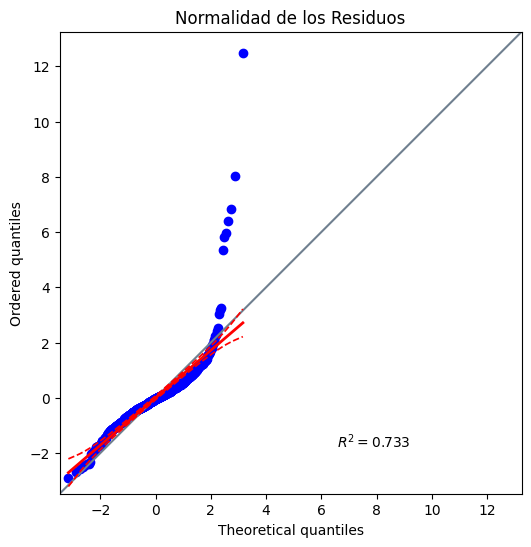

Shapiro p-value: 5.80109446784424e-35
Jarque-Bera p-value: 0.0 



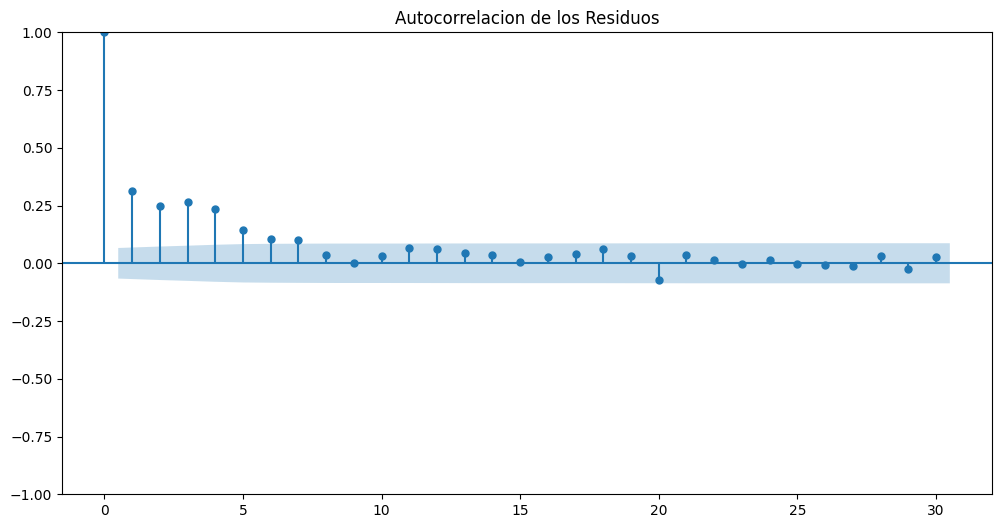

Durbin-Watson (~2 = No-Autocorrelation): 1.185295595196326
Ljung-Box p-value: [7.94626384e-50] 3


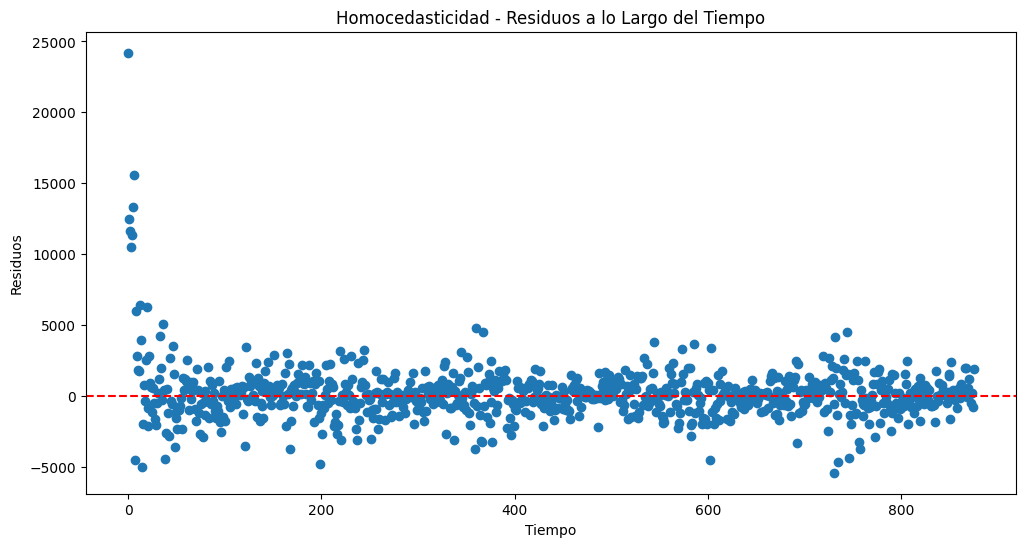

In [39]:
residuos_evaluation(modelo_demanda_sarima.resid)

- Fallaron todos los tests
- Los Residuos de los primeros lags son muy altos. No se lo qeu significa, INVESTIGAR

### 8.1.2 Modelo ARIMA

Media de los Residuos 86.72112527310185


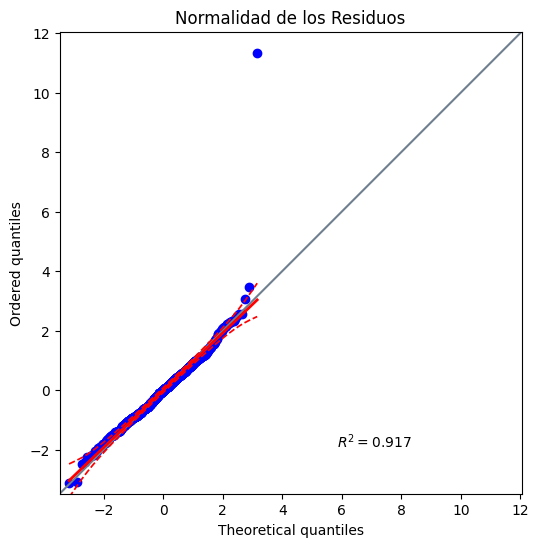

Shapiro p-value: 6.547005301386503e-21
Jarque-Bera p-value: 0.0 



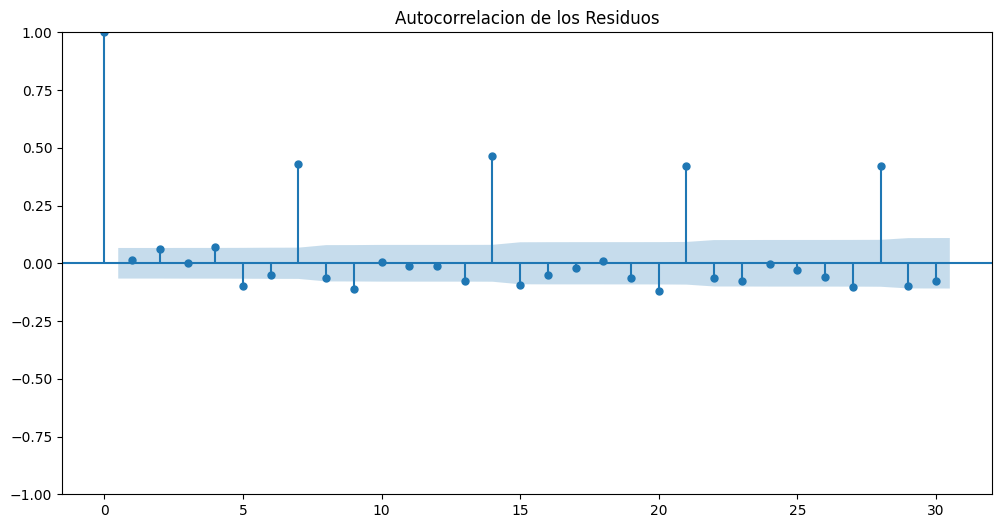

Durbin-Watson (~2 = No-Autocorrelation): 1.8181489052764446
Ljung-Box p-value: [2.00434579e-144] 3


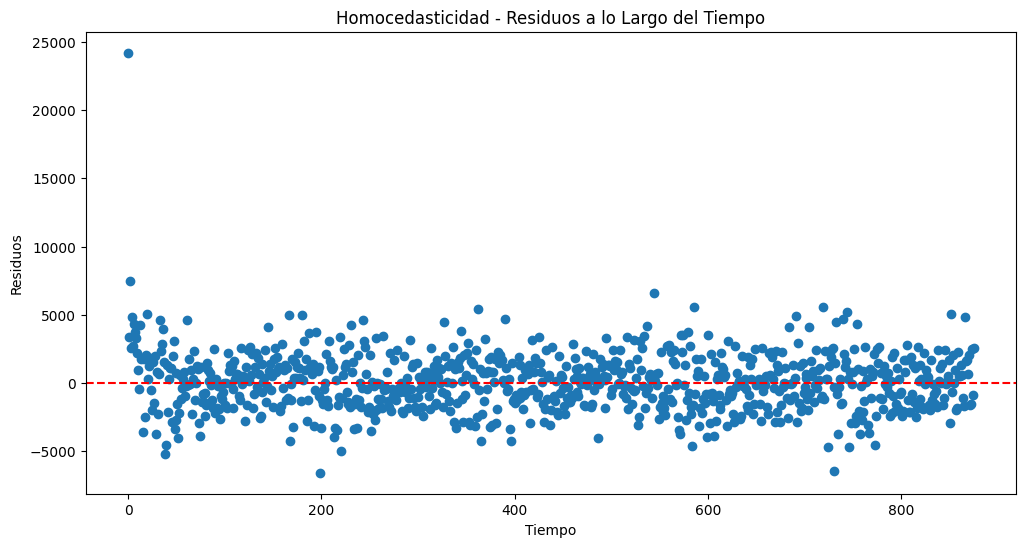

In [40]:
residuos_evaluation(modelo_demanda_arima.resid)

-**Gráficos de Residuos**:
* SARIMA: El gráfico de residuos del modelo SARIMA muestra variaciones a lo largo del tiempo, con algunos picos y valles.
* ARIMA: El gráfico de residuos del modelo ARIMA también muestra variaciones, pero parece tener menos fluctuaciones extremas en comparación con el modelo SARIMA.

-**Test de Durbin-Watson**:
* SARIMA: El valor del test de Durbin-Watson para el modelo SARIMA de Demanda es 1.20, lo que indica una cierta correlación positiva en los residuos.
* ARIMA: El valor del test de Durbin-Watson para el modelo ARIMA de Demanda es 1.82, más cercano a 2, lo que sugiere que hay menos correlación en los residuos.

-**Test de Normalidad (Shapiro-Wilk)**:
* SARIMA: El test de Shapiro-Wilk para el modelo SARIMA de Demanda arroja un valor estadístico de 0.74 y un p-valor extremadamente bajo, lo que indica que los residuos no siguen una distribución normal.
* ARIMA: El test de Shapiro-Wilk para el modelo ARIMA de Demanda arroja un valor estadístico de 0.92 y un p-valor muy bajo, lo que también indica que los residuos no siguen una distribución normal, aunque están más cerca de la normalidad que los residuos del modelo SARIMA.

-**Conclusiones:**
* Los residuos del modelo SARIMA para la serie 'Demanda' muestran más autocorrelación y menos independencia en comparación con los residuos del modelo ARIMA. Esto podría indicar que el modelo SARIMA no está capturando completamente la estructura estacional o de otro tipo en los datos.
* Por otro lado, los residuos del modelo ARIMA parecen ser más independientes, lo que sugiere que este modelo podría estar capturando mejor la estructura subyacente de la serie 'Demanda'.
* En general, el modelo ARIMA parece ser más adecuado para la serie 'Demanda' en comparación con el modelo SARIMA, basado en el análisis de los residuos. Sin embargo, la falta de normalidad en ambos modelos indica que podría ser necesario explorar otras transformaciones o modelos alternativos.

## 8.2 Serie Viento

### 8.2.1 Modelo SARIMA

Media de los Residuos 0.16008552818546207


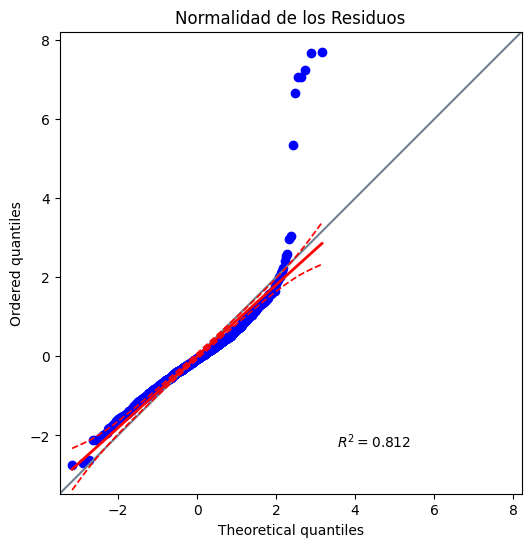

Shapiro p-value: 1.4512048580957899e-30
Jarque-Bera p-value: 0.0 



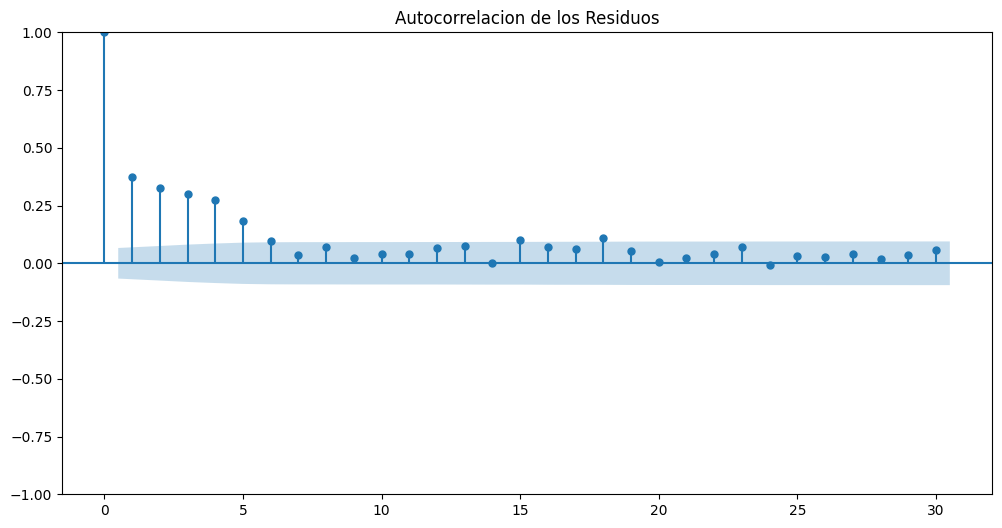

Durbin-Watson (~2 = No-Autocorrelation): 1.2157689555424394
Ljung-Box p-value: [6.24320418e-79] 3


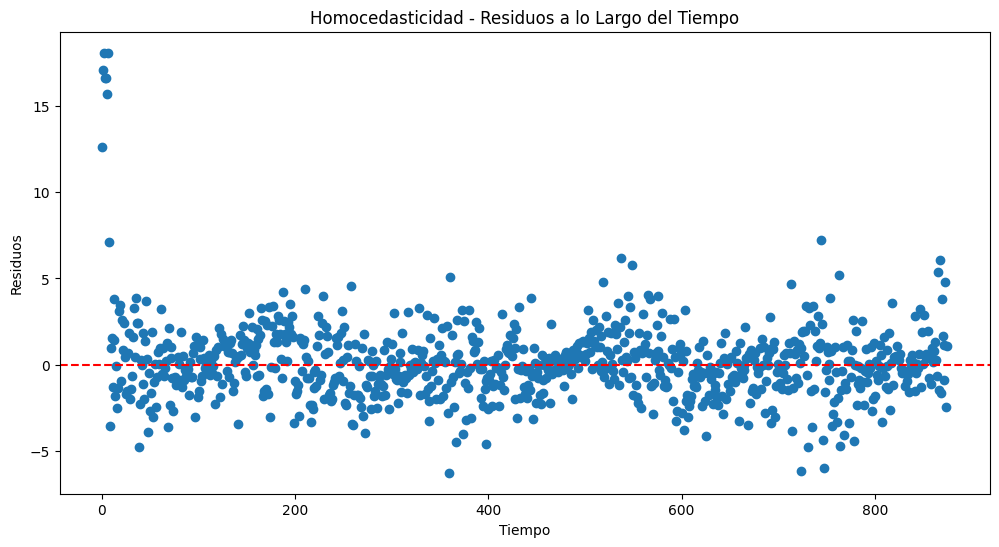

In [41]:
residuos_evaluation(modelo_viento_sarima.resid)

### 8.2.2 Modelo ARIMA

Media de los Residuos 0.04737928112229312


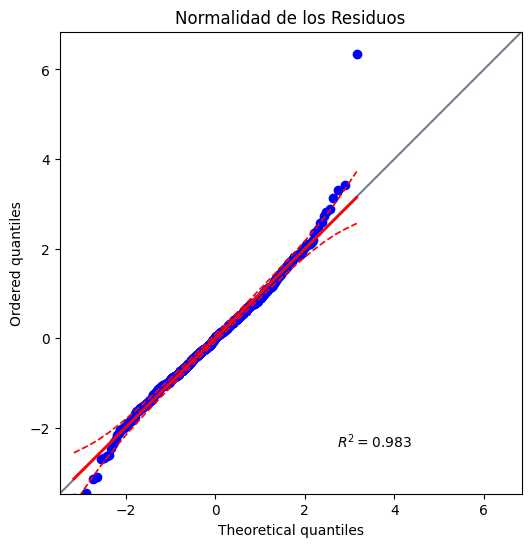

Shapiro p-value: 7.53130748876174e-08
Jarque-Bera p-value: 9.509014360389607e-40 



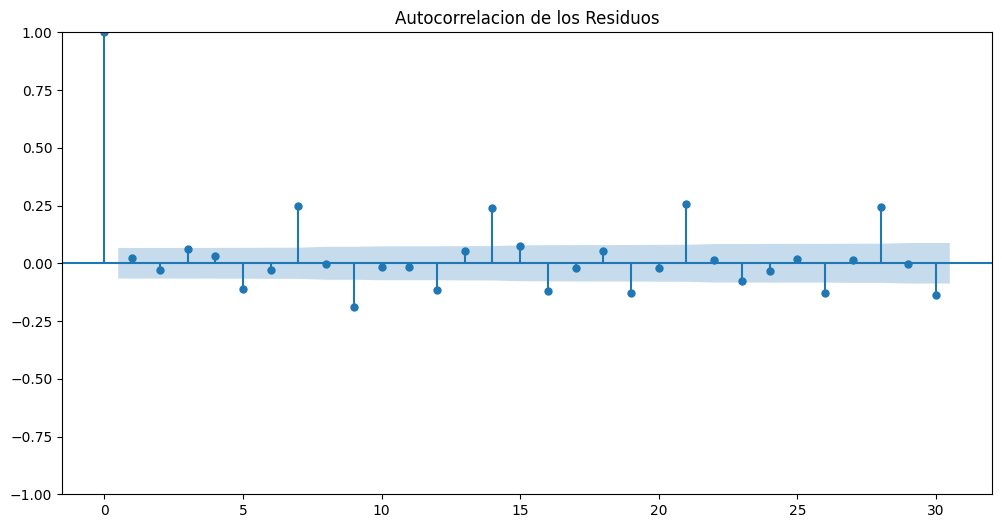

Durbin-Watson (~2 = No-Autocorrelation): 1.9060039560486932
Ljung-Box p-value: [1.99111868e-57] 3


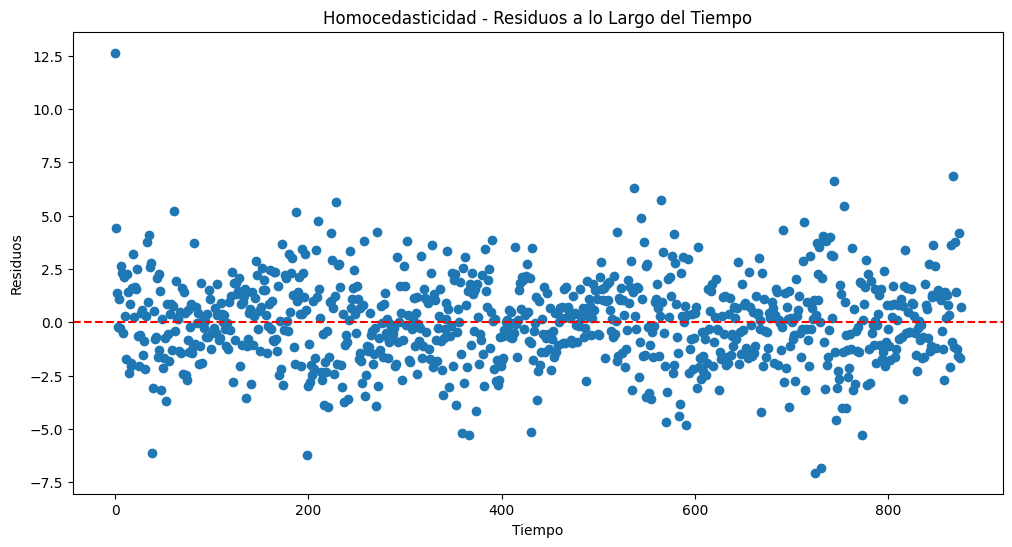

In [42]:
residuos_evaluation(modelo_viento_arima.resid)

-**Test de Normalidad (Shapiro-Wilk)**:
* SARIMA: El test de Shapiro-Wilk para el modelo SARIMA arroja un valor estadístico de 0.81 y un p-valor extremadamente bajo, lo que indica que los residuos no siguen una distribución normal.
* ARIMA: El test de Shapiro-Wilk para el modelo ARIMA arroja un valor estadístico de 0.98 y un p-valor muy bajo, lo que también indica que los residuos no siguen una distribución normal, aunque están más cerca de la normalidad que los residuos del modelo SARIMA.

-**Gráficos de Residuos**:
* SARIMA: El gráfico de residuos del modelo SARIMA muestra variaciones a lo largo del tiempo, lo que podría indicar patrones no capturados por el modelo.
* ARIMA: El gráfico de residuos del modelo ARIMA también muestra variaciones, pero parece tener menos fluctuaciones extremas en comparación con el modelo SARIMA.

-**Autocorrelación de los Residuos**:
* SARIMA: El gráfico de autocorrelación para los residuos del modelo SARIMA muestra algunas correlaciones significativas a diferentes lags. Ademas el valor del test de Durbin-Watson para el modelo SARIMA es 1.22, lo que indica una cierta correlación positiva en los residuos.
* ARIMA: El gráfico de autocorrelación para los residuos del modelo ARIMA muestra menos correlaciones significativas. Tambien el valor del test de Durbin-Watson para el modelo ARIMA es 1.91, más cercano a 2, lo que sugiere que hay menos correlación en los residuos

-**Prueba de Ljung-Box**:
* SARIMA: La prueba de Ljung-Box para los residuos del modelo SARIMA muestra un valor de estadística muy alto y un p-valor extremadamente bajo (prácticamente cero), lo que sugiere que los residuos no son independientes.
* ARIMA: La prueba de Ljung-Box para los residuos del modelo ARIMA muestra un valor de estadística mucho menor y un p-valor más alto, lo que indica que los residuos son más independientes que en el modelo SARIMA.

-**Conclusiones**:
* Los residuos del modelo SARIMA para la serie 'Viento' muestran más autocorrelación y menos independencia en comparación con los residuos del modelo ARIMA. Esto podría indicar que el modelo SARIMA no está capturando completamente la estructura estacional o de otro tipo en los datos.
* Por otro lado, los residuos del modelo ARIMA parecen ser más independientes, lo que sugiere que este modelo podría estar capturando mejor la estructura subyacente de la serie 'Viento'.
* En general, el modelo ARIMA parece ser más adecuado para la serie 'Viento' en comparación con el modelo SARIMA, basado en el análisis de los residuos. Sin embargo, es importante considerar otros aspectos del ajuste del modelo y el contexto de los datos al tomar decisiones finales sobre el modelo más apropiado.

## 8.3 Serie Temperatura

### 8.3.1 Modelo SARIMA

Media de los Residuos 0.09992260146816792


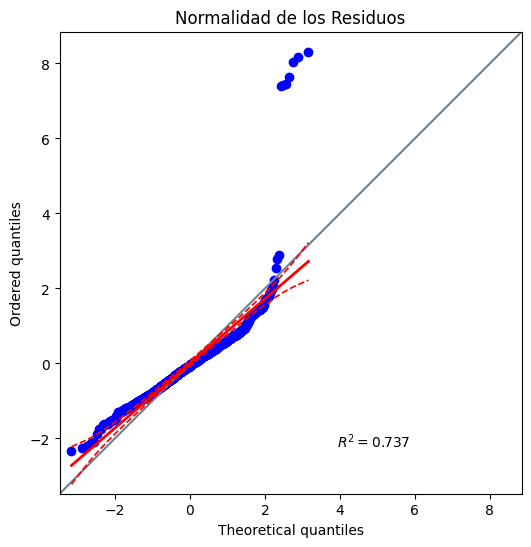

Shapiro p-value: 7.168212190977941e-35
Jarque-Bera p-value: 0.0 



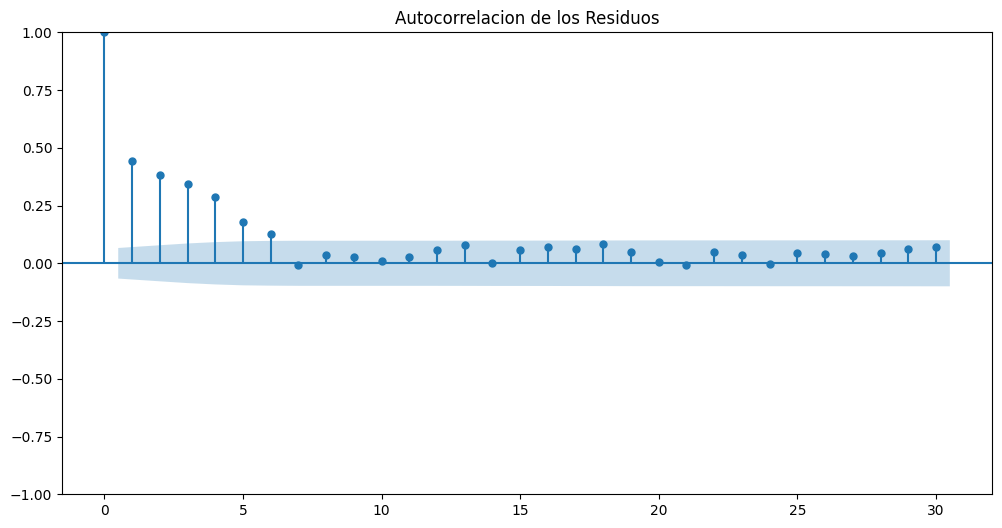

Durbin-Watson (~2 = No-Autocorrelation): 1.0523848899006962
Ljung-Box p-value: [9.91285866e-100] 3


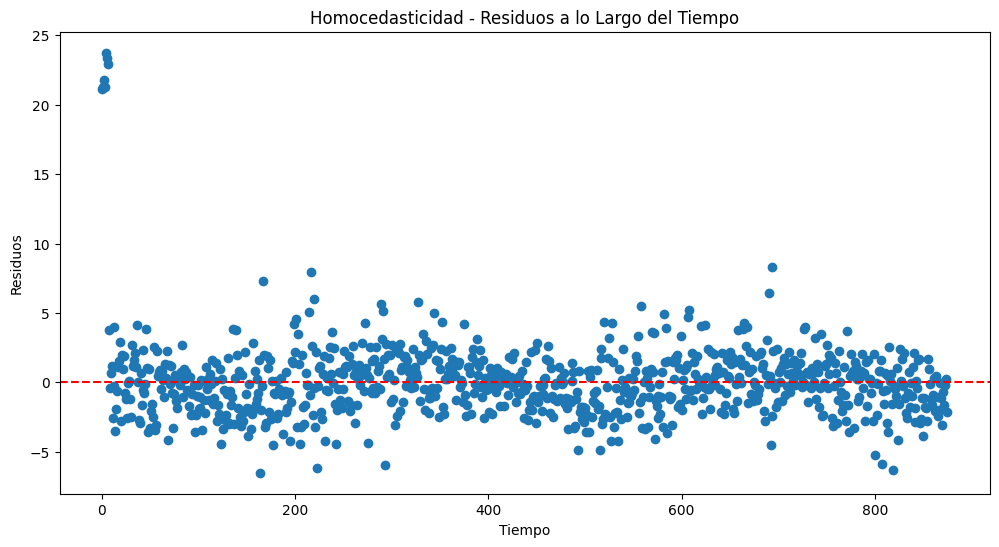

In [43]:
residuos_evaluation(modelo_temperatura_sarima.resid)

### 8.3.2 Modelo ARIMA

Media de los Residuos -0.01618096421614351


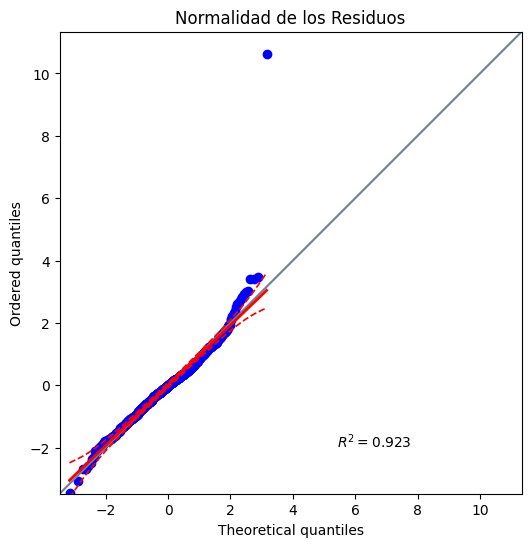

Shapiro p-value: 3.5305054051914896e-20
Jarque-Bera p-value: 0.0 



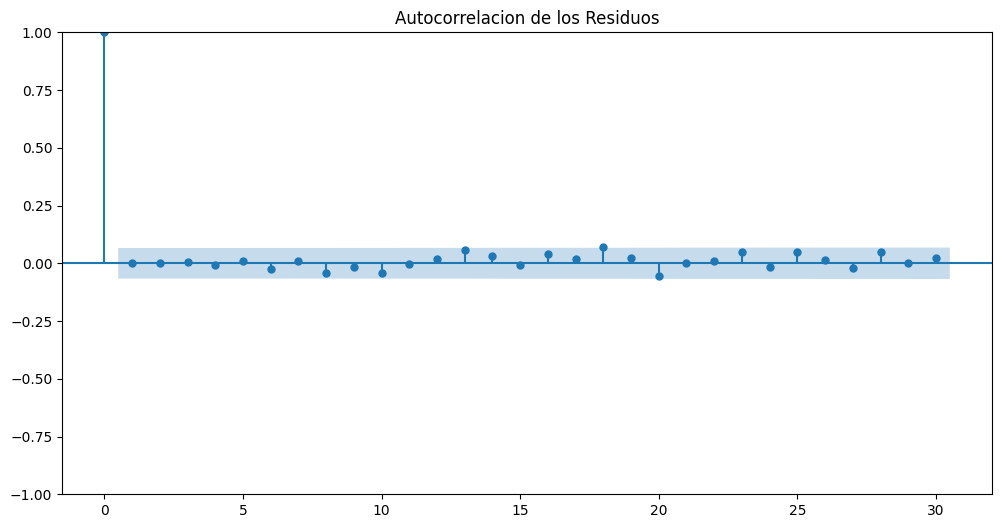

Durbin-Watson (~2 = No-Autocorrelation): 1.8704379027528897
Ljung-Box p-value: [0.6761631] 3


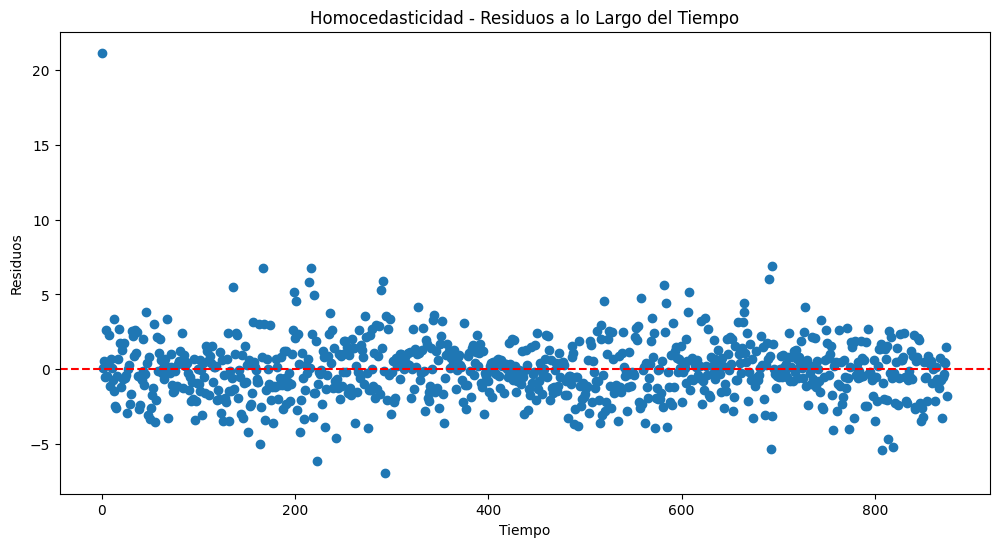

In [44]:
residuos_evaluation(modelo_temperatura_arima.resid)

-**Test de Normalidad (Shapiro-Wilk)**:
* SARIMA: El test de Shapiro-Wilk para el modelo SARIMA de Temperatura arroja un valor estadístico de 0.74 y un p-valor extremadamente bajo, lo que indica que los residuos no siguen una distribución normal.
* ARIMA: El test de Shapiro-Wilk para el modelo ARIMA de Temperatura arroja un valor estadístico de 0.93 y un p-valor muy bajo, lo que también indica que los residuos no siguen una distribución normal, aunque están más cerca de la normalidad que los residuos del modelo SARIMA.

-**Gráficos de Residuos**:
* SARIMA: El gráfico de residuos del modelo SARIMA muestra variaciones a lo largo del tiempo, lo que podría indicar patrones no capturados por el modelo.
* ARIMA: El gráfico de residuos del modelo ARIMA también muestra variaciones, pero parece tener menos fluctuaciones extremas en comparación con el modelo SARIMA.

-**Autocorrelación de los Residuos**:
* SARIMA: El valor del test de Durbin-Watson para el modelo SARIMA de Temperatura es 1.05, lo que indica una correlación positiva significativa en los residuos.
* ARIMA: El valor del test de Durbin-Watson para el modelo ARIMA de Temperatura es 1.87, más cercano a 2, lo que sugiere que hay menos correlación en los residuos.

-**Prueba de Ljung-Box**:
* SARIMA: La prueba de Ljung-Box para los residuos del modelo SARIMA muestra un valor de estadística muy alto y un p-valor extremadamente bajo, lo que sugiere que los residuos no son independientes.
* ARIMA: La prueba de Ljung-Box para los residuos del modelo ARIMA muestra un valor de estadística mucho menor y un p-valor alto, lo que indica que los residuos son más independientes que en el modelo SARIMA.

-**Conclusiones**:
* Los residuos del modelo SARIMA para la serie 'Temperatura' muestran más autocorrelación y menos independencia en comparación con los residuos del modelo ARIMA. Esto podría indicar que el modelo SARIMA no está capturando completamente la estructura estacional o de otro tipo en los datos.
* Por otro lado, los residuos del modelo ARIMA parecen ser más independientes, lo que sugiere que este modelo podría estar capturando mejor la estructura subyacente de la serie 'Temperatura'.
* En general, el modelo ARIMA parece ser más adecuado para la serie 'Temperatura' en comparación con el modelo SARIMA, basado en el análisis de los residuos. Sin embargo, es importante considerar otros aspectos del ajuste del modelo y el contexto de los datos al tomar decisiones finales sobre el modelo más apropiado.



# 9. Pronosticar el comportamiento de cada Serie para el Mes de Enero 2023


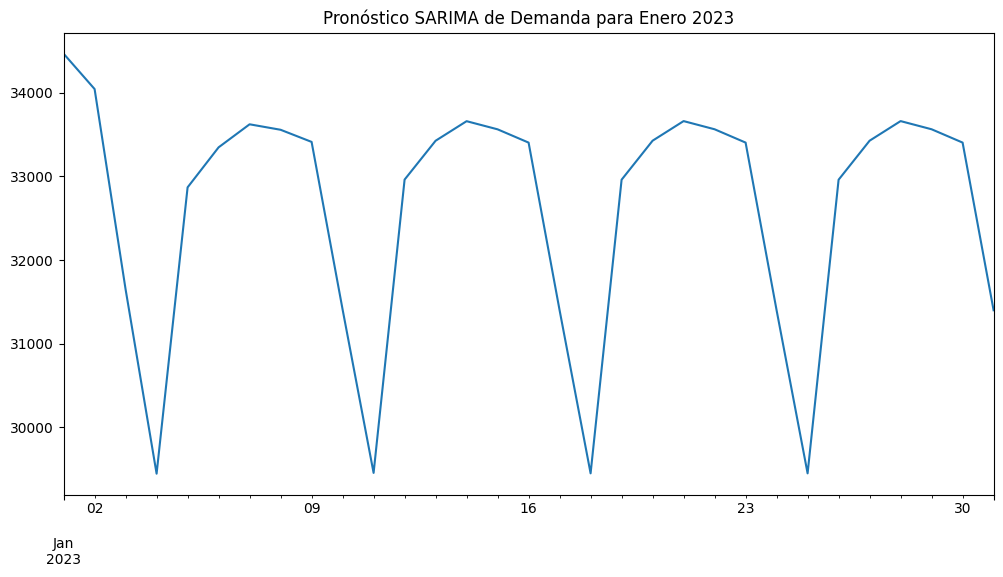

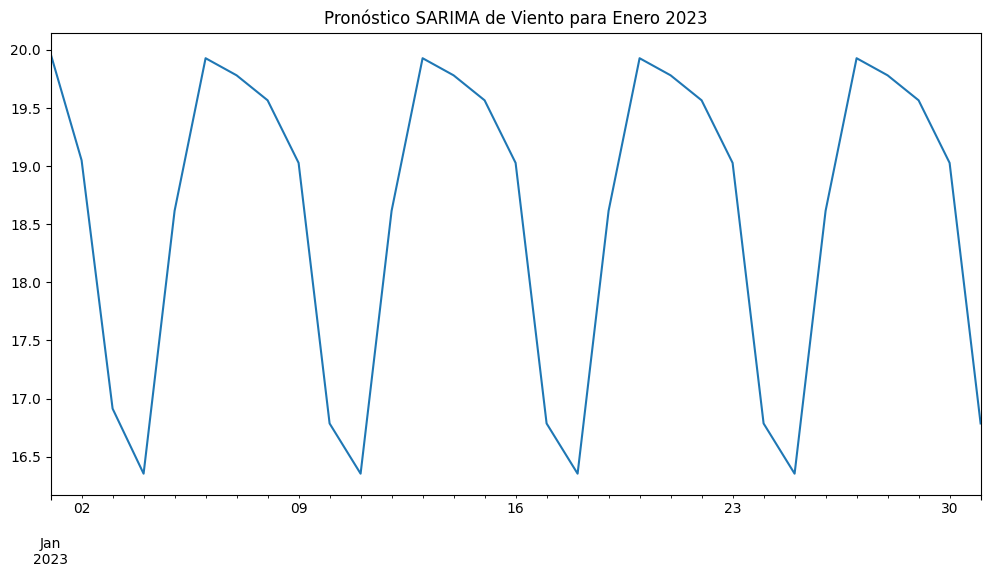

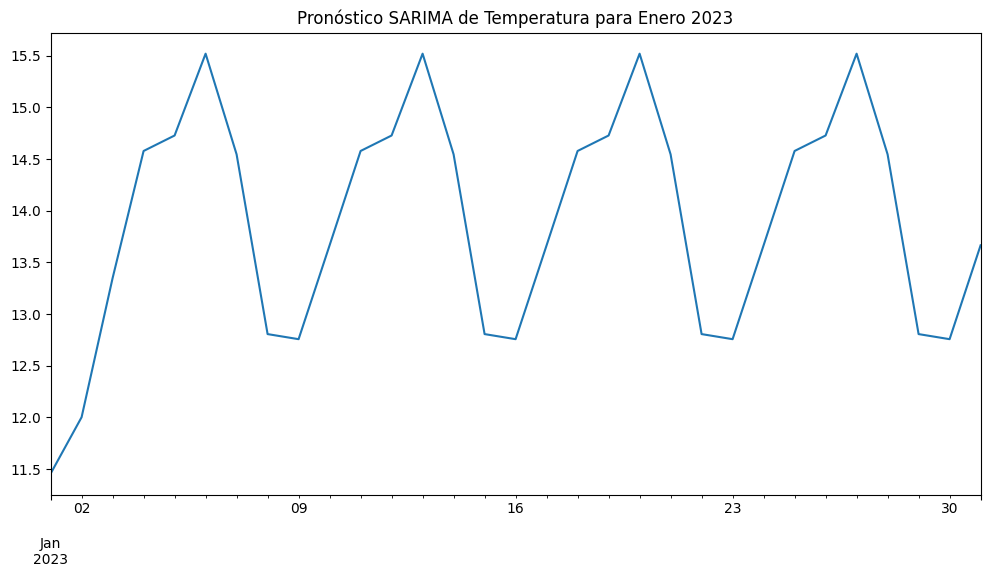

In [52]:
# Calcular el número de pasos desde la última fecha de los datos hasta Enero de 2023
ultimo_dato_fecha = data.index[-1]
fecha_inicio_enero2023 = pd.Timestamp('2023-01-01')
pasos_hasta_enero2023 = (fecha_inicio_enero2023 - ultimo_dato_fecha).days

# Conversión de la última fecha de los datos a Timestamp si es necesario
if not isinstance(ultimo_dato_fecha, pd.Timestamp):
    ultimo_dato_fecha = pd.Timestamp(ultimo_dato_fecha)

# Calcular el número de pasos desde la última fecha de los datos hasta Enero de 2023
pasos_hasta_enero2023 = (fecha_inicio_enero2023 - ultimo_dato_fecha).days
# Asegurarse de que el número de pasos de pronóstico sea correcto
pasos_correctos = pasos_hasta_enero2023 + 30 # 30 días para enero

# Ajustar los pronósticos para comenzar en Enero de 2023
pred_demanda_sarima_enero2023 = modelo_demanda_sarima.get_forecast(steps=pasos_correctos).predicted_mean
pred_demanda_sarima_enero2023.index = pd.date_range(start='2023-01-01', periods=pasos_correctos, freq='D')
pred_demanda_sarima_enero2023.plot()
plt.title('Pronóstico SARIMA de Demanda para Enero 2023')
plt.show()

pred_viento_sarima_enero2023 = modelo_viento_sarima.get_forecast(steps=pasos_correctos).predicted_mean
pred_viento_sarima_enero2023.index = pd.date_range(start='2023-01-01', periods=pasos_correctos, freq='D')
pred_viento_sarima_enero2023.plot()
plt.title('Pronóstico SARIMA de Viento para Enero 2023')
plt.show()

pred_temperatura_sarima_enero2023 = modelo_temperatura_sarima.get_forecast(steps=pasos_correctos).predicted_mean
pred_temperatura_sarima_enero2023.index = pd.date_range(start='2023-01-01', periods=pasos_correctos, freq='D')
pred_temperatura_sarima_enero2023.plot()
plt.title('Pronóstico SARIMA de Temperatura para Enero 2023')
plt.show()

# 10. Construir un modelo de Vectores Autorregresivos (VAR) con las series elegidas para realizar predicciones sobre cada una de ellas